In [1]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F
from torch.optim import Adam
import numpy as np
from tqdm.auto import tqdm
import umap
import umap.plot
import pandas as pd
from warnings import filterwarnings
from torchsummary import summary

2022-11-05 13:23:18.540933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
fmnist_train = datasets.FashionMNIST(root='Fashion_mnist/',train=True,transform=ToTensor(),download=False)
fmnist_test  = datasets.FashionMNIST(root='Fashion_mnist/',train=False,transform=ToTensor(),download=False)

In [3]:
fmnist_train_loader = DataLoader(dataset=fmnist_train,batch_size=32)
fmnist_test_loader = DataLoader(dataset=fmnist_test,batch_size=32)

In [4]:
cifar10_train = datasets.CIFAR10(root='CIFAR-10/',train=True,transform=ToTensor(),download=False)
cifar10_test = datasets.CIFAR10(root='CIFAR-10/',train=False,transform=ToTensor(),download=False)

In [5]:
cifar10_train_loader = DataLoader(dataset=cifar10_train,batch_size=32)
cifar10_test_loader = DataLoader(dataset=cifar10_test,batch_size=32)

In [6]:
filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
from helpers import visualize_dataset

In [8]:
batch_idx, (example_data,example_target) = next(enumerate(fmnist_test_loader))

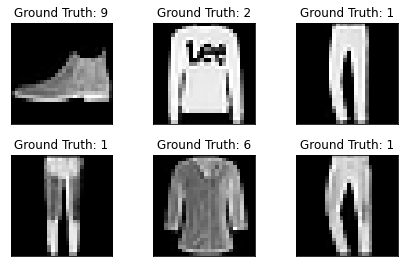

In [13]:
visualize_dataset(example_data=example_data,example_targets=example_target,channel_size=1)

In [14]:
class VAE(nn.Module):
    
    def __init__(self,input_dim,latent_dim):
        super(VAE,self).__init__()
        
        
        self.encoder = nn.Sequential(
            
            nn.Linear(input_dim,256),
            nn.LeakyReLU(),
            nn.Linear(256,128),
            nn.LeakyReLU(),
            )
        
        self.mean    = nn.Linear(128,latent_dim)
        self.log_var = nn.Linear(128,latent_dim)
        
        self.decoder = nn.Sequential(
            
            nn.Linear(latent_dim,128),
            nn.LeakyReLU(),
            nn.Linear(128,256),
            nn.LeakyReLU(),
            nn.Linear(256,input_dim),
            nn.LeakyReLU()
        
        )
        
        
    def reparameterize(self,z_mean,z_log_var):
        
        eps = torch.randn(z_mean.size(0),z_mean.size(1))
        z = z_mean + torch.exp(z_log_var/2) * eps
        
        return z
    
    def forward(self,x):

        x = self.encoder(x)
        z_mean, z_log_var = self.mean(x), self.log_var(x)
        encoded = self.reparameterize(self.mean(x), self.log_var(x))
        decoded = self.decoder(encoded)
        
        return encoded, z_mean, z_log_var, decoded
        

In [15]:
#vae_model = VAE(input_dim=28*28,latent_dim=20)

In [16]:
#optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.0003)  

In [17]:
def vae_loss(decoded,x,z_mean,z_log_var):
    
    x = x.view(x.size(0),-1)
    
    recons = F.mse_loss(decoded, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    
    return recons + kl

In [18]:
def train(model,train_loader,optimizer,loss_fn,device,EPOCH):
    
    with tqdm(total=len(train_loader)*EPOCH) as tt:
        
        model.train()
        
        for epoch in range(EPOCH):
            
            total_loss, batch_count = 0, 0
            
            for idx, (batch,_) in enumerate(train_loader):
                
                batch = batch.view(batch.size(0),-1)
                #print(batch.shape)
                encoded, z_mean, z_log_var, reconstruction = model(batch)
                
                
                loss = loss_fn(reconstruction,batch,z_mean,z_log_var)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                batch_count +=1
                tt.update()
                
                
            total_loss = total_loss / batch_count
            print(f'{total_loss}')
                
                
    

In [19]:
#train(model=vae_model,train_loader=fmnist_train_loader,optimizer=optimizer,loss_fn=vae_loss,device=device,EPOCH=20)
#torch.save(vae_model,'models/vae_linear_model.pt')
vae_model = torch.load('models/vae_linear_model.pt')

In [22]:
def visualize_resultsVAE(model,data_loader,data):
    dataiter = iter(data_loader)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    images, labels = dataiter.next()
    
    images_flatten = images.view(images.size(0), -1)
    _,_,_,output = model(images_flatten)
    
    images = images.numpy()
    output = output.view(32, 1, 28, 28)


    output = output.cpu().detach().numpy()

    fig, axes = plt.subplots(nrows=2, ncols=15, sharex=True, sharey=True, figsize=(25,4))

    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            
            ax.imshow((np.transpose(img,(1, 2, 0))*255).astype(np.uint8),cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


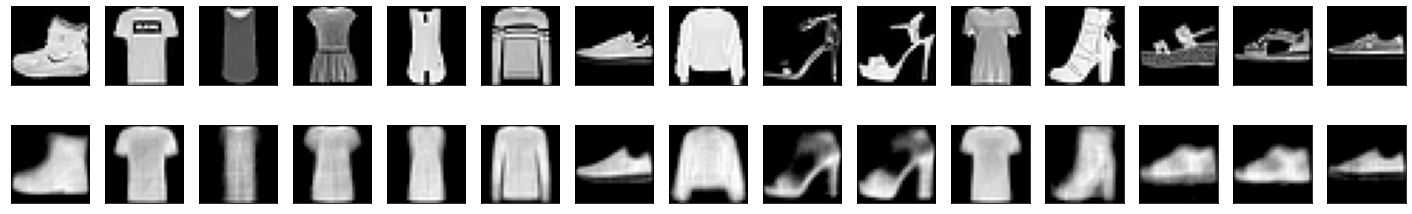

In [23]:
visualize_resultsVAE(model=vae_model,data_loader=fmnist_train_loader,data='fmnist')

In [24]:
def generate_random_imgs(model,nsample):
    
    rand_features = torch.randn(nsample, 20)
    rand_generated = model.decoder(rand_features)
    
    images = rand_generated.view(nsample,1,28,28)
    images = images.cpu().detach().numpy()
    
    for i in range(12):
            plt.subplot(3,4,i+1)
            plt.tight_layout()
            plt.imshow(images[i][0], cmap='gray')
            plt.xticks([])
            plt.yticks([])
    

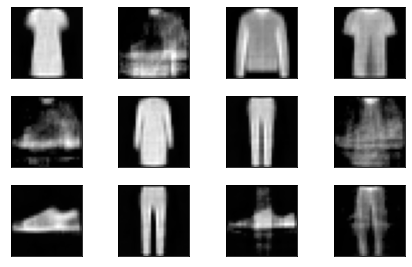

In [25]:
generate_random_imgs(vae_model,12)

# ConvVAE

In [26]:
class ConvVAE(nn.Module):
    
    def __init__(self,latent_dim=200):
        super().__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels=3,out_channels=32,stride=1,kernel_size=5), #32x32x3 --> 28x28x16
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32,out_channels=32,stride=1,kernel_size=3), #28x28x16 --> 26x26x32
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32,out_channels=32,stride=2,kernel_size=4), #26x26x32 --> 12x12x32
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,stride=1,kernel_size=3), #12x12x32 --> 10x10x64
            nn.LeakyReLU(),
        )
        
        
        self.mean    = nn.Linear(6400,latent_dim)
        self.log_var = nn.Linear(6400,latent_dim)
        self.linear  = nn.Linear(latent_dim,6400) 
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=32,stride=1,kernel_size=3), # 10x10x64 --> 12x12x32
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32,out_channels=32,stride=2,kernel_size=4), # 12x12x32 --> 26x26x32
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32,out_channels=32,stride=1,kernel_size=3), # 26x26x32 --> 28x28x16
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32,out_channels=3,stride=1,kernel_size=5), # 28x28x16 --> 32x32x3
        )
        
    def reparameterize(self,z_mean,z_log_var):
        
        eps = torch.randn(z_mean.size(0),z_mean.size(1))
        z = z_mean + torch.exp(z_log_var/2) * eps
        
        return z
        
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = x.view(x.size(0),-1)
        z_mean, z_log_var = self.mean(x), self.log_var(x)
        
        
        encoded = self.reparameterize(self.mean(x), self.log_var(x))
        
        x = self.linear(encoded)
        
        x = x.view(x.size(0),64,10,10)
        
        decoded = self.decoder(x)
        
        
        return encoded, z_mean, z_log_var, decoded 

In [27]:
def conv_train(model,train_dataloader,optimizer,device,loss_fn,EPOCH=30):
    
    with tqdm(total = len(train_dataloader) * EPOCH) as tt:
        
        model.train()
        
        for epoch in range(EPOCH):
            
            total_loss, batch_count = 0, 0
            
            for idx,(batch,_) in enumerate(train_dataloader):
                
                encoded, z_mean, z_log_var, reconstruction = model(batch).to(device)
                
                loss = loss_fn(reconstruction,batch,z_mean,z_log_var)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                
                total_loss += loss.item()
                batch_count += 1
                tt.update()
                
            total_loss = total_loss / batch_count
            print(f'{total_loss}')


In [28]:
conv_vae_model = torch.load('models/conv_vae_705e-4.pt',map_location=torch.device('cpu'))

In [29]:
#optimizer = torch.optim.Adam(conv_vae_model.parameters(), lr=0.0003)  

In [30]:
#conv_train(model=conv_vae_model,train_dataloader=cifar10_train_loader,optimizer=optimizer,loss_fn=vae_loss,device=device,EPOCH=20)

In [47]:
def generate_random_imgs_conv(model,nsample):
    
    rand_features = torch.randn(nsample, 200)
    x = model.linear(rand_features)
    x = x.view(x.size(0),64,10,10) 
    rand_generated = model.decoder(x)
    
    images = rand_generated.view(nsample,3,32,32)
    images = images.cpu().detach().numpy()
    
    for i in range(12):
            plt.subplot(3,4,i+1)
            plt.tight_layout()
            plt.imshow(np.transpose((images[i]*255).astype(np.uint8),(1, 2, 0)))
            plt.xticks([])
            plt.yticks([])
    

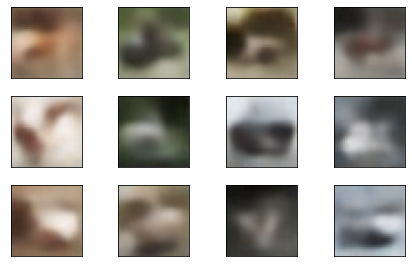

In [48]:
generate_random_imgs_conv(conv_vae_model,12)